In [1]:
#load the necessary packages
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

In [6]:
#path to scp csv file
import os
path = 'C://Users//soura//spe_challenge'   # Define your own path 
ifile = 'Supercapacitor CCD - Lig-NiWO4(1).csv'
df = pd.read_csv(os.path.join(path,ifile))

In [7]:
df.head()

,cycle,lignin,NiWO4,pvdf,csp
0,1,80,10,10,4.104299
1,2,80,10,10,3.025478
2,3,80,10,10,2.517516
3,4,80,10,10,2.265924
4,5,80,10,10,2.089968


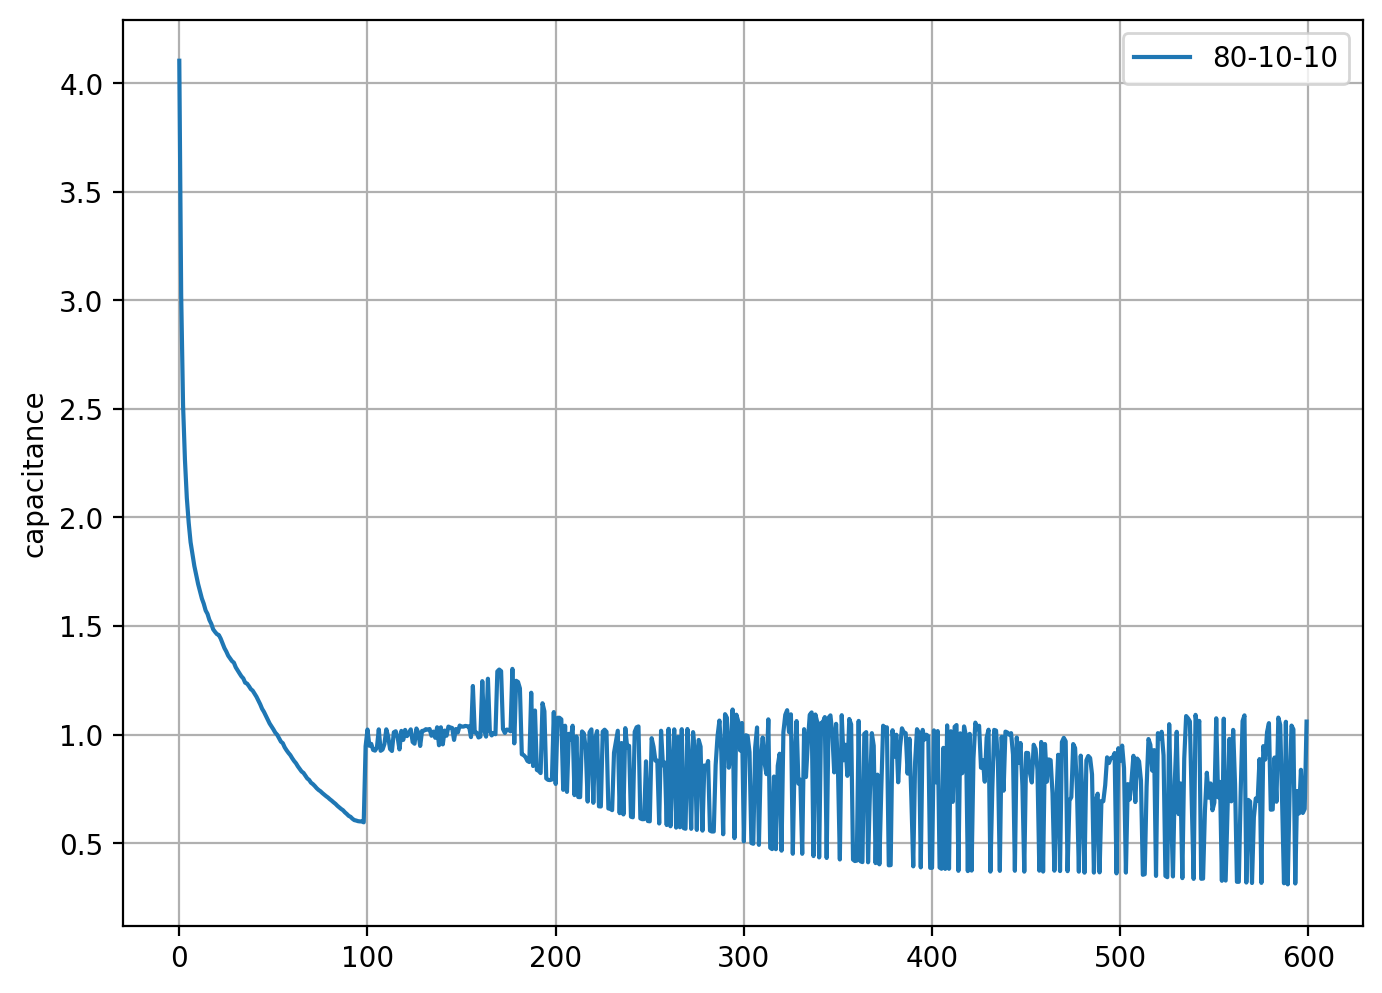

In [27]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=1, figsize=(8, 6),dpi =200, facecolor='w', edgecolor='k')
data1 = plt.plot(df.index,df['csp'],label='80-10-10')
#data2 = plt.plot(df1.index,df1['csp'],label='45-45-10')
#data3 = plt.plot(df2.index,df2['csplabel='10-80-10')
#plt.legend(['80-10-10', '45-45-10','10-80-10'], loc='upper right')
plt.legend(['80-10-10'], loc='upper right')
plt.ylabel('capacitance')
plt.xlabel(df.index.name)
plt.grid(True)
plt.show()

In [14]:
cycle=len(df.index)

In [15]:
cycle

600

In [16]:
#Splitting the Training set and Test set in 60:40 ratio


train_size = int(len(df)*0.6)

train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

In [17]:
train_dataset.tail()

,cycle,lignin,NiWO4,pvdf,csp
355,356,80,10,10,0.809713
356,357,80,10,10,1.071656
357,358,80,10,10,1.046975
358,359,80,10,10,0.423806
359,360,80,10,10,0.417197


In [19]:
test_dataset.head()

,cycle,lignin,NiWO4,pvdf,csp
360,361,80,10,10,0.419108
361,362,80,10,10,1.062898
362,363,80,10,10,0.416003
363,364,80,10,10,0.412341
364,365,80,10,10,1.003185


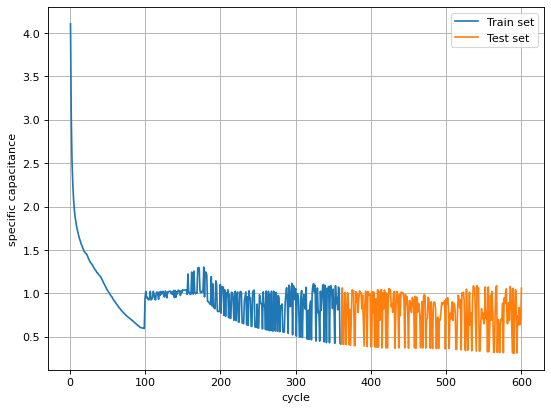

In [30]:
#Plotting the training and test set
figure(num=2, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_dataset.cycle,train_dataset.csp)
plt.plot(test_dataset.cycle,test_dataset.csp)
plt.xlabel('cycle')
plt.ylabel('specific capacitance')
plt.legend(['Train set', 'Test set'], loc='upper right')
plt.grid(True)

In [50]:
#splitting the train data to X and Y
#training data is the averaged data to reduce overfitting
X_train = train_dataset.drop('csp',axis=1)
y_train = train_dataset.loc[:,['csp']]


In [34]:
X_train=X_train.values.reshape(-1,1)

In [35]:
y_train=y_train.values.reshape(-1,1)

In [51]:
#splitting the test data to X and Y
X_test = test_dataset.drop('csp',axis=1)
y_test = test_dataset.loc[:,['csp']]
#y_real_test = test_dataset['OIL']

In [37]:
X_test=X_test.values.reshape(-1,1)

In [38]:
y_test=y_test.values.reshape(-1,1)

In [52]:
#y_real_test = y_real_test.values.reshape(-1,1)
X_train.shape


(360, 4)

In [42]:
y_train.shape


(360, 1)

In [43]:
X_test.shape


(960, 1)

In [44]:
y_test.shape

(240, 1)

In [53]:
#transforming all data points
#feature range can be -1 to 1 or 0 to 1. Trying -1 to 1
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

In [54]:
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

In [55]:
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

In [56]:
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)
#test_y_real_norm = output_scaler.transform(y_test)

In [58]:


def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 5 # random time lag

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
#X_test, Y_real_test = create_dataset(test_x_norm, test_y_real_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)
#rint('Y_test.shape: ', Y_real_test.shape)

X_train.shape:  (355, 5, 4)
Y_train.shape:  (355, 1)
X_test.shape:  (235, 5, 4)
Y_test.shape:  (235, 1)


In [59]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units, return_sequences = True))                 
    model.add(Dropout(0.2))
    #model.add(Dense(units = 1))
    # Third layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# BiLSTM
model_bilstm = create_model_bilstm(128)

# GRU and LSTM 
model_gru = create_model(128, GRU)
model_lstm = create_model(128, LSTM)

In [60]:
model_bilstm.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 256)            136192    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 530,689
Trainable params: 530,689
Non-trainable params: 0
_________________________________________________________________


In [61]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 128)            51456     
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 5, 128)            99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [682]:
model_lstm.summary()

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_126 (LSTM)              (None, 6, 128)            66560     
_________________________________________________________________
dropout_110 (Dropout)        (None, 6, 128)            0         
_________________________________________________________________
lstm_127 (LSTM)              (None, 6, 128)            131584    
_________________________________________________________________
dropout_111 (Dropout)        (None, 6, 128)            0         
_________________________________________________________________
lstm_128 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_112 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)               

In [63]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 50)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 500, validation_split = 0.2,
                    batch_size = 8, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/500
36/36 [==============================] - 1s 41ms/step - loss: 0.0164 - val_loss: 0.0071
Epoch 2/500
36/36 [==============================] - 0s 8ms/step - loss: 0.0095 - val_loss: 0.0087
Epoch 3/500
36/36 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 4/500
36/36 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 5/500
36/36 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 6/500
36/36 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 7/500
36/36 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 8/500
36/36 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 9/500
36/36 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 10/500
36/36 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 11

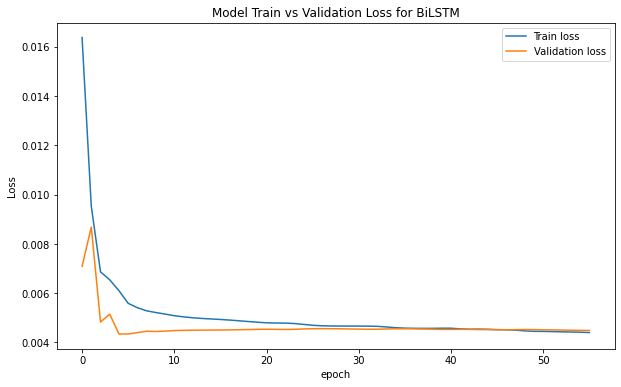

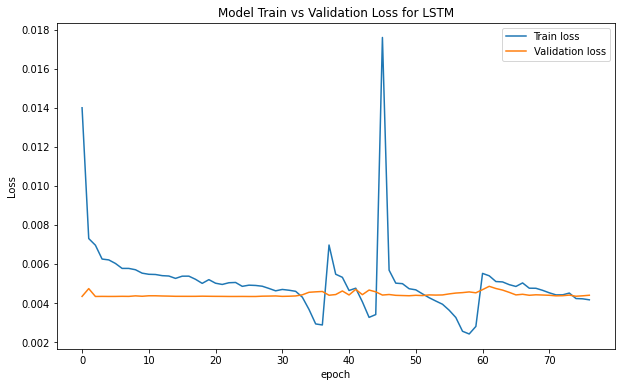

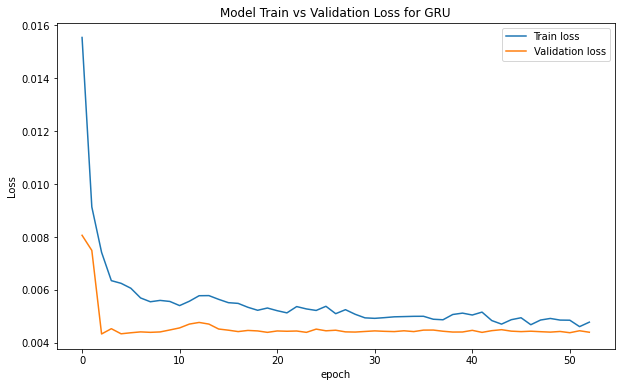

In [64]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [65]:
Y_test = scaler_y.inverse_transform(y_test)
Y_train = scaler_y.inverse_transform(y_train)
#Y_real_test=scaler_y.inverse_transform(Y_train)

In [66]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

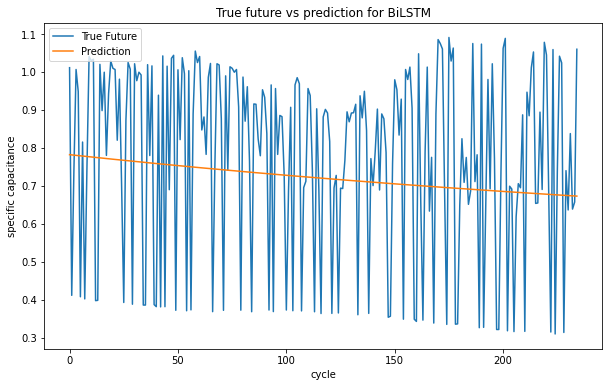

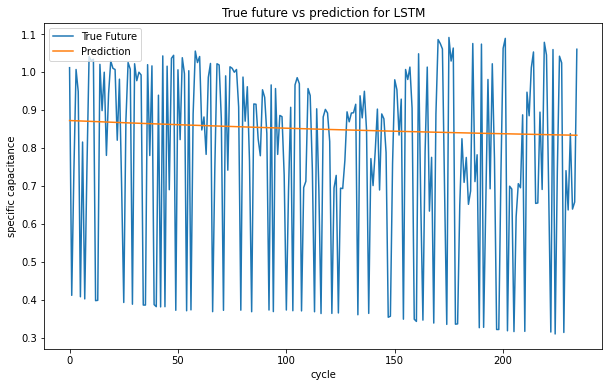

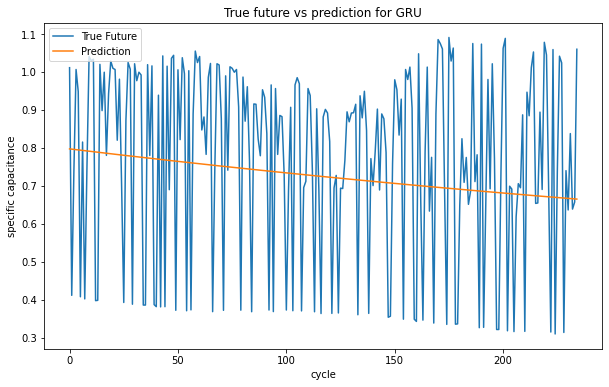

In [67]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(Y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('cycle')
    plt.ylabel('specific capacitance')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'BiLSTM', Y_test)
plot_future(prediction_lstm, 'LSTM', Y_test)
plot_future(prediction_gru, 'GRU', Y_test)

In [68]:
len(np.array(prediction_lstm))

235

In [69]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_bilstm, Y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, Y_test, 'LSTM')
evaluate_prediction(prediction_gru, Y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 0.2146
Root Mean Square Error: 0.2506

LSTM:
Mean Absolute Error: 0.2015
Root Mean Square Error: 0.2585

GRU:
Mean Absolute Error: 0.2130
Root Mean Square Error: 0.2500

